# Fase de Modelización 

## Carga del modelo MovilNet

En este primer punto vamos a cargar el modelo MovilNet para iniciar la fase de entrenamiento del modelo con los datos obtenidos en la fase de preanalisis y resolución. Luego probaremos una segunda parte con una CNN creada desde cero para contrastar resultados

### 1. Importamos las librerias que necesitamos para instanciar el modelo 

In [124]:
from IPython.display import display, Javascript

display(Javascript('IPython.notebook.kernel.restart()'))

<IPython.core.display.Javascript object>

In [7]:
%run imports.py

In [8]:
df_reducido = pd.read_csv("prueba.csv")
df_reducido.shape

(19000, 3)

In [3]:
dataframe = pd.read_csv("output/model_photosv1.0.csv")
dataframe.head()

,photo_id,business_id,caption,label
0,6LJa8QZOGBjt9maE5miLhw,368cyArdo0P0aDUOhhE4PA,Drive-thru menu,menu
1,T_QaBsquJlzAQd5bbCrLfA,jwpZzqoPFLuHE-FwLp41cQ,Courtyard at Bistro di Marino,outside
2,DtsfhqhqUB-tjs5XbwJfXw,s-74t4aQKL2pWeQmIB-c1Q,Vegan Options,menu
3,Iehiw_bcHnXw-pg0w2M06w,64jKdxGGwfHx4rutBBKWBQ,"New Keto Protein Punch! 15g protein, 3g of car...",drink
4,JClkivVTbSvCJAsdqtOa2g,ToqcYJVdnrp4fefaucm-Vg,NaN,inside


In [4]:
# Limpieza de columnas innecesarias
dataframe.drop(columns=["business_id", "caption"], inplace=True)
dataframe.head()

,photo_id,label
0,6LJa8QZOGBjt9maE5miLhw,menu
1,T_QaBsquJlzAQd5bbCrLfA,outside
2,DtsfhqhqUB-tjs5XbwJfXw,menu
3,Iehiw_bcHnXw-pg0w2M06w,drink
4,JClkivVTbSvCJAsdqtOa2g,inside


In [5]:
image_paths = []
for image in dataframe['photo_id']: 
    image_paths.append(os.path.join("photos", f'{image}.jpg'))

In [7]:
dataframe['path_files'] = image_paths
dataframe = dataframe.reindex(columns=['photo_id', 'path_files', 'label'])
dataframe.head()

,photo_id,path_files,label
0,6LJa8QZOGBjt9maE5miLhw,photos\6LJa8QZOGBjt9maE5miLhw.jpg,menu
1,T_QaBsquJlzAQd5bbCrLfA,photos\T_QaBsquJlzAQd5bbCrLfA.jpg,outside
2,DtsfhqhqUB-tjs5XbwJfXw,photos\DtsfhqhqUB-tjs5XbwJfXw.jpg,menu
3,Iehiw_bcHnXw-pg0w2M06w,photos\Iehiw_bcHnXw-pg0w2M06w.jpg,drink
4,JClkivVTbSvCJAsdqtOa2g,photos\JClkivVTbSvCJAsdqtOa2g.jpg,inside


In [8]:
#Resultado final
dataframe = dataframe[["path_files", "label"]]
dataframe.head()

,path_files,label
0,photos\6LJa8QZOGBjt9maE5miLhw.jpg,menu
1,photos\T_QaBsquJlzAQd5bbCrLfA.jpg,outside
2,photos\DtsfhqhqUB-tjs5XbwJfXw.jpg,menu
3,photos\Iehiw_bcHnXw-pg0w2M06w.jpg,drink
4,photos\JClkivVTbSvCJAsdqtOa2g.jpg,inside


In [9]:
# Funcion check_path: verifica que todas las imagenes se abren correctamente mediante la columna "path_files"
def check_path(data):
    t = 0 
    f = 0  
    for path in tqdm(data['path_files'], desc='Procesando rutas'): 
        try:
            t += 1
            Image.open(path)
        except Exception as e:
            f += 1
            
    return t, f

check_path(df_reducido)

Procesando rutas:   0%|          | 0/19000 [00:00<?, ?it/s]

Procesando rutas: 100%|██████████| 19000/19000 [00:39<00:00, 481.17it/s]


(19000, 0)

In [12]:
def image_label_load(data): 
    images = []
    labels = []

    for image_path, label in tqdm(zip(data['path_files'].tolist(), data['label'].tolist()), desc="Codificando imagenes"):
        try: 
            img = Image.open(image_path).resize((244,244)).convert('RGB')
            images.append(np.array(img))
            labels.append(np.array(label))
        except Exception as e: 
            print(f"{e} Levantado tras ejecutar la ruta {image_path}")
    
    return np.array(images), np.array(labels)

images, labels = image_label_load(df_reducido)

# Codificar las etiquetas
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded, num_classes=5)  # Asegúrate de especificar 5 clases

print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels_encoded.shape}")

Codificando imagenes: 19000it [02:26, 130.06it/s]


Shape of images: (19000, 244, 244, 3)
Shape of labels: (19000, 5)


In [13]:
# Carga del MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244,244,3))

# Congelar capas base del modelo -> Conserva los pesos establecidos por el aprendizaje de imagenet
base_model.trainable = False 

#Añadimos capas superiores para ajustar el modelo a nuestro caso concreto: 

x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation='relu')(x) 

predictions = Dense(5, activation='softmax')(x) # Ajuste para 5 clases (menu, outside, drink, inside, food)

# Instancia del MobileNetV2 + capas superiores 
model = Model(inputs=base_model.input, outputs=predictions)

# Compilacion del modelo en conjunto: 

model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


C:\Users\varel\AppData\Local\Temp\ipykernel_17672\3325738747.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244,244,3))


In [17]:
# Train/Test split -> Division  de conjuntos de datos en entrenamiento y validacion 

X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.25, random_state=41)


# Data Augmentation --> para ganar mas variedad de datos a la hora de entrenar 
"""
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
"""
                ### HIPER-PARAMETROS DE DATA AUGMENTATION PARA ENTRENAMIENTO ###
datagen = ImageDataGenerator()
# Ajustamos el generador de datos al conjunto de entrenamiento 

datagen.fit(X_train)

MemoryError: Unable to allocate 9.48 GiB for an array with shape (14250, 244, 244, 3) and data type float32

In [14]:
# Numero de pasos por epoch
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
# Entrenar el modelo
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10


c:\Users\varel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5724 - loss: 1.0641 - val_accuracy: 0.6857 - val_loss: 0.8369
Epoch 2/10
  1/186 ━━━━━━━━━━━━━━━━━━━━ 2:50 922ms/step - accuracy: 0.7500 - loss: 0.6652

c:\Users\varel\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


186/186 ━━━━━━━━━━━━━━━━━━━━ 63s 333ms/step - accuracy: 0.7500 - loss: 0.6652 - val_accuracy: 0.6722 - val_loss: 0.8834
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.7349 - loss: 0.7123 - val_accuracy: 0.7304 - val_loss: 0.7312
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 59s 313ms/step - accuracy: 0.8750 - loss: 0.3978 - val_accuracy: 0.7349 - val_loss: 0.7264
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.7865 - loss: 0.5819 - val_accuracy: 0.7309 - val_loss: 0.7249
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 58s 311ms/step - accuracy: 0.7812 - loss: 0.5416 - val_accuracy: 0.7269 - val_loss: 0.7245
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8003 - loss: 0.5448 - val_accuracy: 0.7380 - val_loss: 0.7192
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 58s 309ms/step - accuracy: 0.7500 - loss: 0.6184 - val_accuracy: 0.7440 - val_loss: 0.7104
Epoch 9/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8175 - loss: 0.4819 - val_accurac

63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 947ms/step
F1-score: 0.7509442516345276
Accuracy: 0.7449799196787149
              precision    recall  f1-score   support

       drink       0.75      0.68      0.72       403
        food       0.84      0.75      0.79       400
      inside       0.54      0.82      0.65       361
        menu       0.91      0.76      0.83       425
     outside       0.78      0.71      0.75       403

    accuracy                           0.74      1992
   macro avg       0.77      0.75      0.75      1992
weighted avg       0.77      0.74      0.75      1992



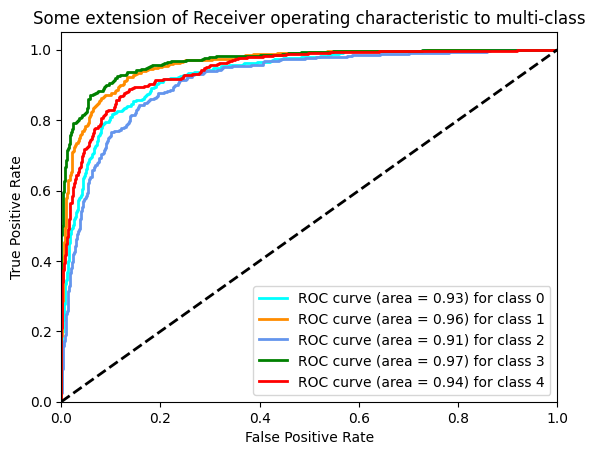

In [15]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


# Calcular el F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f'F1-score: {f1}')

# Calcular el accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Generar el reporte de clasificación
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print(report)

# Generar la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear todas las curvas ROC
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0]) # apuntar 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: name 'df_valid' is not defined